In [11]:
import torchio as tio
import os
import nibabel as nib
import numpy as np
import torch
import pandas as pd

from monai.metrics import compute_average_surface_distance, get_confusion_matrix
from collections.abc import Sequence
from monai.metrics.utils import get_mask_edges, get_surface_distance, ignore_background, prepare_spacing
from monai.utils import convert_data_type, convert_to_tensor
from tqdm import tqdm

from scipy import ndimage
#from scipy.ndimage import label

In [12]:
# metric class
class Metric:
    def __init__(self, GT, PRED):
        self.gt = GT
        self.pred = PRED
        
        # metric list
        self.DC_list = []
        self.DG_numerator = []
        self.DG_denominator = []
        self.Jaccard_list = []
        self.VOE_list = []
        self.RVD_list = []
        self.RAVD_list = []
        self.ASSD_list = []
        self.RMSD_list = []
        self.MSSD_list = []
        self.TP_list = []
        self.TN_list = []
        self.FP_list = []
        self.FN_list = []
        self.SEN_list = []
        self.SPE_list = []
        
    def cal_DC_and_DG(self):
        # inersection, union, dice 계산
        intersection = (self.pred*self.gt).sum()
        union = self.pred.sum() + self.gt.sum()
        dice = 2*intersection/union
        
        self.DG_numerator.append(intersection)
        self.DG_denominator.append(union)
        self.DC_list.append(dice) # save
    
    def cal_Jaccard_and_VOE(self):
        intersection = (self.pred*self.gt).sum()
        union = self.pred.sum() + self.gt.sum() - (self.pred*self.gt).sum()
        jaccard = intersection/union
        
        self.Jaccard_list.append(jaccard)
        self.VOE_list.append(1-jaccard)
    
    # RAVD equation: by CotepRes-Net
    def cal_RVD_and_RAVD(self):
        numerator = self.pred.sum() - self.gt.sum()
        denominator = self.pred.sum() # another paper mentioned, self.gt.sum()
        RVD = numerator/denominator
        
        self.RVD_list.append(RVD)
        self.RAVD_list.append(abs(RVD))
    
    # average symmetric surface distance (ASD or ASSD)
    def cal_ASSD(self):
        # monai module
        # compute_average_surface_distance
        assd = compute_average_surface_distance(self.pred, self.gt, symmetric=True)
        
        self.ASSD_list.append(assd)
    
    # root mean symmetric surface distance (RMSD)
    def cal_RMSD(self):
        rmsd = self.compute_root_mean_surface_distance(symmetric=True)
        
        self.RMSD_list.append(rmsd)
        
    # Maximum symmetric surface distance (MSD)
    def cal_MSSD(self):
        mssd = self.compute_maximum_surface_distance()
        
        self.MSSD_list.append(mssd)
    
    def cal_CONFUSION_MATRIX(self):
        pred, gt = torch.Tensor(self.pred), torch.Tensor(self.gt)
        confusion_matrix = get_confusion_matrix(pred, gt, include_background=False)
        tp, fp, tn, fn = confusion_matrix[0,0,...] #  3D -> 1D
        SEN = tp/(tp+fn)
        SPE = tn/(tn+fp)
        
        self.TP_list.append(tp)
        self.TN_list.append(tn)
        self.FP_list.append(fp)
        self.FN_list.append(fn)
        
        self.SEN_list.append(SEN)
        self.SPE_list.append(SPE)
    
    def print_metric(self):
        print("DC score(upper):", self.DC_list[0])
        #print("DG score(upper):", self.DG_numerator[0]/self.DG_denominator[0])
        print("Jaccard score(upper):", self.Jaccard_list[0])
        print("VOE score(lower):", self.VOE_list[0])
        #print("RVD score(lower):", self.RVD_list[0])
        print("RAVD score(lower):", self.RAVD_list[0])
        print("ASSD score(lower):", self.ASSD_list[0].item())
        print("RMSD score(lower):", self.RMSD_list[0].item())
        print("MSSD score(lower):", self.MSSD_list[0].item())
        print("SEN score(upper):", self.SEN_list[0].item())
        print("SPE score(upper):", self.SPE_list[0].item())
    
    def save_metric(self):
        return self.DC_list[0], self.Jaccard_list[0], self.VOE_list[0], self.RAVD_list[0], self.ASSD_list[0].item(), \
                    self.RMSD_list[0].item(), self.MSSD_list[0].item(), self.SEN_list[0].item(), self.SPE_list[0].item()
    
    def all_calculation(self):
        print("######### Start! ######### ")
        self.cal_DC_and_DG()
        self.cal_Jaccard_and_VOE()
        self.cal_RVD_and_RAVD()
        self.cal_ASSD()
        self.cal_RMSD()
        self.cal_MSSD()
        self.cal_CONFUSION_MATRIX()
        print("######### Done! ######### ")
    
    ############### Refereces by Monai
    def compute_root_mean_surface_distance(
        self,
        include_background = False,
        symmetric = True,
        distance_metric = "euclidean",
        spacing = None):

        if not include_background:
            y_pred, y = ignore_background(y_pred=self.pred, y=self.gt)
        else:
            y_pred, y = self.pred.copy(), self.gt.copy()

        y_pred = convert_data_type(y_pred, output_type=torch.Tensor, dtype=torch.float)[0]
        y = convert_data_type(y, output_type=torch.Tensor, dtype=torch.float)[0]

        if y.shape != y_pred.shape:
            raise ValueError(f"y_pred and y should have same shapes, got {y_pred.shape} and {y.shape}.")

        batch_size, n_class = y_pred.shape[:2]
        asd = torch.empty((batch_size, n_class), dtype=torch.float32, device=y_pred.device)

        img_dim = y_pred.ndim - 2
        spacing_list = prepare_spacing(spacing=spacing, batch_size=batch_size, img_dim=img_dim)

        for b, c in np.ndindex(batch_size, n_class):
            _, distances, _ = self.get_edge_surface_distance(
                y_pred[b, c],
                y[b, c],
                distance_metric=distance_metric,
                spacing=spacing_list[b],
                symmetric=symmetric,
                class_index=c,
            )
            surface_distance = torch.cat(distances)
            asd[b, c] = torch.tensor(np.nan) if surface_distance.shape == (0,) else torch.sqrt(torch.mean((surface_distance)**2))
            
        return convert_data_type(asd, output_type=torch.Tensor, device=y_pred.device, dtype=torch.float)[0]
    
    # Make MSSD
    def compute_maximum_surface_distance(
        self,
        include_background = False,
        symmetric = True,
        distance_metric = "euclidean",
        spacing = None):

        if not include_background:
            y_pred, y = ignore_background(y_pred=self.pred, y=self.gt)
        else:
            y_pred, y = self.pred.copy(), self.gt.copy()

        y_pred = convert_data_type(y_pred, output_type=torch.Tensor, dtype=torch.float)[0]
        y = convert_data_type(y, output_type=torch.Tensor, dtype=torch.float)[0]

        if y.shape != y_pred.shape:
            raise ValueError(f"y_pred and y should have same shapes, got {y_pred.shape} and {y.shape}.")

        batch_size, n_class = y_pred.shape[:2]
        asd = torch.empty((batch_size, n_class), dtype=torch.float32, device=y_pred.device)

        img_dim = y_pred.ndim - 2
        spacing_list = prepare_spacing(spacing=spacing, batch_size=batch_size, img_dim=img_dim)

        for b, c in np.ndindex(batch_size, n_class):
            _, distances, _ = self.get_edge_surface_distance(
                y_pred[b, c],
                y[b, c],
                distance_metric=distance_metric,
                spacing=spacing_list[b],
                symmetric=symmetric,
                class_index=c,
            )
            surface_distance = torch.cat(distances)
            asd[b, c] = torch.tensor(np.nan) if surface_distance.shape == (0,) else max(surface_distance)
            
        return convert_data_type(asd, output_type=torch.Tensor, device=y_pred.device, dtype=torch.float)[0]
    
    # get_edge_surface_distance
    def get_edge_surface_distance(
        self,
        y_pred,
        y,
        distance_metric = "euclidean",
        spacing: "int | float | np.ndarray | Sequence[int | float] | None" = None,
        use_subvoxels: bool = False,
        symmetric: bool = False,
        class_index: int = -1):
        
        edges_spacing = None
        if use_subvoxels:
            edges_spacing = spacing if spacing is not None else ([1] * len(y_pred.shape))
        
        (edges_pred, edges_gt, *areas) = get_mask_edges(y_pred, y, crop=True, spacing=edges_spacing, always_return_as_numpy=False)
        
        if symmetric:
            distances = (
                get_surface_distance(edges_pred, edges_gt, distance_metric, spacing),
                get_surface_distance(edges_gt, edges_pred, distance_metric, spacing),
            )  # type: ignore
        else:
            distances = (get_surface_distance(edges_pred, edges_gt, distance_metric, spacing),)  # type: ignore
            
        return convert_to_tensor(((edges_pred, edges_gt), distances, tuple(areas)), device=y_pred.device)  # type: ignore[no-any-return]

In [13]:
# calculation function
def calculation_all_metric(GT, PRED):
    metric = Metric(GT, PRED)
    metric.all_calculation()
    metric.print_metric()
    
    return metric.save_metric()

In [14]:
def remove_all_but_the_largest_connected_component(image: np.ndarray, for_which_classes: list, volume_per_voxel: float,
                                                   minimum_valid_object_size: dict = None):
    """
    removes all but the largest connected component, individually for each class
    :param image:
    :param for_which_classes: can be None. Should be list of int. Can also be something like [(1, 2), 2, 4].
    Here (1, 2) will be treated as a joint region, not individual classes (example LiTS here we can use (1, 2)
    to use all foreground classes together)
    :param minimum_valid_object_size: Only objects larger than minimum_valid_object_size will be removed. Keys in
    minimum_valid_object_size must match entries in for_which_classes
    :return:
    """
    if for_which_classes is None:
        for_which_classes = np.unique(image)
        for_which_classes = for_which_classes[for_which_classes > 0]

    assert 0 not in for_which_classes, "cannot remove background"
    largest_removed = {}
    kept_size = {}
    for c in for_which_classes:
        if isinstance(c, (list, tuple)):
            c = tuple(c)  # otherwise it cant be used as key in the dict
            mask = np.zeros_like(image, dtype=bool)
            for cl in c:
                mask[image == cl] = True
        else:
            mask = image == c
        # get labelmap and number of objects
        lmap, num_objects = ndimage.label(mask.astype(int))

        # collect object sizes
        object_sizes = {}
        for object_id in range(1, num_objects + 1):
            object_sizes[object_id] = (lmap == object_id).sum() * volume_per_voxel

        largest_removed[c] = None
        kept_size[c] = None

        if num_objects > 0:
            # we always keep the largest object. We could also consider removing the largest object if it is smaller
            # than minimum_valid_object_size in the future but we don't do that now.
            maximum_size = max(object_sizes.values())
            kept_size[c] = maximum_size

            for object_id in range(1, num_objects + 1):
                # we only remove objects that are not the largest
                if object_sizes[object_id] != maximum_size:
                    # we only remove objects that are smaller than minimum_valid_object_size
                    remove = True
                    if minimum_valid_object_size is not None:
                        remove = object_sizes[object_id] < minimum_valid_object_size[c]
                    if remove:
                        image[(lmap == object_id) & mask] = 0
                        if largest_removed[c] is None:
                            largest_removed[c] = object_sizes[object_id]
                        else:
                            largest_removed[c] = max(largest_removed[c], object_sizes[object_id])
    return image, largest_removed, kept_size

In [15]:
def post_processing(data, whole=False):
    
    
    processed, largest_removed, kept_size = remove_all_but_the_largest_connected_component(
        image=data,
        for_which_classes=[1],
        volume_per_voxel=3,
        minimum_valid_object_size=None  # 이 인자는 생략하거나 None으로 설정할 수 있dma
        )

    processed = ndimage.median_filter(processed, size=3)

    #klcc_transform=KeepLargestConnectedComponent(applied_labels=[1], is_onehot=None, independent=False, connectivity=True, num_components=1)
    
    #processed=klcc_transform(data)

    #erosioned = ndimage.binary_erosion(processed, iterations=3)
    
    #dilationed = ndimage.binary_dilation(erosioned, iterations=3)
    
    #processed = np.where(dilationed == 0,0,1)
    
    return processed

In [17]:
# Setting
data = input("Dataset names(3Dircadb, LiTS, Sliver):")
if data in ['3Dircadb', 'LiTS', 'Sliver']:
    if data == 'LiTS':
        extension = '.nii'
    elif data == '3Dircadb':
        extension = '.nii.gz'
    else:
        extension = '.mhd'
    print("Extension:", extension)
    
    # define path (설정)
    gt_folder = './DATASET_Synapse/unetr_pp_raw/unetr_pp_raw_data/Task02_Synapse/Task002_Synapse/seg_gt/' + data + '/'
    pred_folder = './output_synapse/3d_fullres/Task002_Synapse/unetr_pp_trainer_synapse__unetr_pp_Plansv2.1/fold_4/validation_raw/'
    mask_folder = './DATASET_Synapse/unetr_pp_raw/unetr_pp_raw_data/Task02_Synapse/Task002_Synapse/masking/' + data + '/'
    
    os.makedirs(mask_folder, exist_ok=True)
    
    # make nii files
    flag_post = True
    pred_name = os.listdir(pred_folder)
    pred_name = [nii for nii in pred_name if extension in nii]
    print(len(pred_name)) # LiTS: 20

    # 기타 변수 (rotation 안 되어 있다면 활용)
    ## If you come tumor github, please use another tmp_lst variables.
    tmp_lst=['volume-15.nii', 'volume-18.nii', 'volume-28.nii', 'volume-3.nii', 'volume-33.nii', 'volume-37.nii', 'volume-42.nii', 'volume-47.nii', 'volume-5.nii', 'volume-54.nii', 'volume-70.nii', 'volume-73.nii', 'volume-80.nii']

else:
    print("No dataset")

Dataset names(3Dircadb, LiTS, Sliver):LiTS
Extension: .nii
1


In [25]:
metric_df = pd.DataFrame(columns=['LiTS_id', 'DC', 'Jaccard', 'VOE', 'RAVD', 'ASSD', 'RMSD', 'MSSD', 'SEN', 'SPE'])

for i in tqdm(range(len(pred_name))):
    resize = tio.Resize((256, 256, -1))
    pred = tio.ScalarImage(os.path.join(pred_folder, pred_name[i]))
    if data == 'LiTS':
        gt = nib.load(os.path.join(gt_folder, pred_name[i].replace('volume', 'segmentation')))   
        real_data = gt.get_fdata()
    elif data == 'Sliver':
        gt = nib.load(os.path.join(gt_folder, pred_name[i].replace('orig', 'seg')[:-4]+'.mhd'))
        real_data = gt.get_fdata()
    else:
        gt = nib.load(os.path.join(gt_folder, pred_name[i].replace('volume', 'segmentation')+'.gz')) # 3Dircadb
        real_data = gt.get_fdata()
        
    pred = np.array(pred)
    pred = pred[0]
    if flag_post: # post-processing
        pred = post_processing(pred)
    
    pred = pred.astype('int')
    pred = pred.transpose(2,1,0)
    
    nifti_file = nib.Nifti1Image(pred, gt.affine, )#real.header)
    mask_file_name = pred_name[i].replace('volume', 'masking')
    nifti_file.to_filename(os.path.join(mask_folder, mask_file_name))  # Save as NiBabel files

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.07s/it]


## mask apply

In [26]:
mask_path = './DATASET_Synapse/unetr_pp_raw/unetr_pp_raw_data/Task02_Synapse/Task002_Synapse/masking/LiTS/masking-100.nii'
ct_path = './DATASET_Synapse/unetr_pp_raw/unetr_pp_raw_data/Task02_Synapse/Task002_Synapse/unetr_pp_Data_plans_v2.1_stage1/LiTS/volume-100.nii'

# mask files
masking = tio.ScalarImage(mask_path)
masking = np.array(masking)
masking = np.transpose(masking[0], (2,1,0))

# ct files
resize = tio.Resize((256,256,-1))
a = tio.ScalarImage(ct_path)
a = np.array(a)
a = resize(a) # input: 4D
a = np.clip(a, -250, 250) # Zhu et al. paper (2024) // HU values / -250, 250

a = (a - np.min(a)) / (np.max(a) - np.min(a)) # normalize - preprocessing
a = np.transpose(a[0], (2,1,0)) # TODO: 9/24 axial

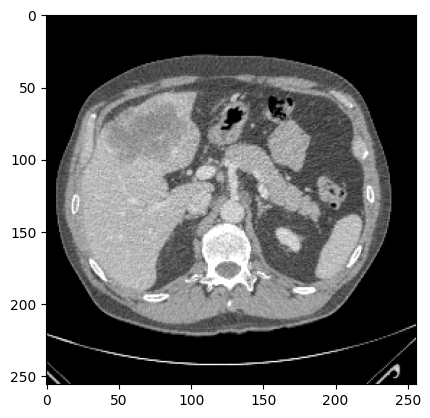

In [27]:
import matplotlib.pyplot as plt
plt.imshow(a[500], cmap='gray')

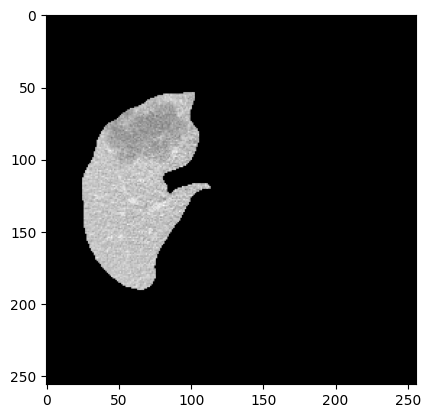

In [28]:
a = np.where(masking==0, 0, a) # mask 적용
plt.imshow(a[500], cmap='gray')